# Fellowship.ai: Code Challenge

In this challenge, I'm going to use an Imagewoof dataset and a pretrained ResNet 50 to demonstrate why initial layers are frozen during the first few epochs of transfer learning. Secondly,  to demonstrate whether my model do better or worse when I freezed the initial layers for the first few epochs.

In [1]:
#Importing the basic libraries. I will import additional libraries when required
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
from tensorflow.keras.layers import Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
import cv2
import numpy as np
import warnings
from tensorflow.keras.applications.resnet50 import ResNet50
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
from tensorflow.keras.utils import to_categorical
import time
import pickle
from operator import truediv

# What I'm going to cover in the challenge?

1). First, I will explore the Imagewoof dataset for Image Classification.
2). 1 will use a pretrained Tensorflow ResNet50 model for the Imagewoof dataset image classification.
3). After training and saving the trained model, I will evaluate and check the performance of the model. This will give us a good idea of how well the model has been trained.

5). Finally, we will discuss the takeaways from this coding challenge and what we can do to improve it further.


In [6]:
#Creating the Dataset
#The Data Loaders

train_filelist  = []
val_filelist  = []

for dirname, _, filenames in os.walk('/home/cqdx/Clinton/image_data/Data/train/'):
    for filename in filenames:
        train_filelist.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/home/cqdx/Clinton/image_data/Data/val/'):
    for filename in filenames:
        val_filelist.append(os.path.join(dirname, filename))
        
        
print('Number of training files:', len(train_filelist))
print('Number of validation files:', len( val_filelist))


Number of training files: 12454
Number of validation files: 500


In [7]:
Train_filepaths   = []
Train_labels = []
for image_file in train_filelist:
    label = image_file.split(os.path.sep)[-2]

    Train_filepaths.append(image_file)
    Train_labels.append(label)
    
Val_filepaths   = []
Val_labels = []
for image_file in val_filelist:
    label = image_file.split(os.path.sep)[-2]

    Val_filepaths.append(image_file)
    Val_labels.append(label)
    
Train_df = pd.DataFrame(list(zip(Train_filepaths, Train_labels)), columns = ['Train_filepath', 'Train_Labels'] )
Train_df = (Train_df.sample(frac = 1, random_state=42).reset_index()).drop(columns = 'index')
print(Train_df.head())


Val_df = pd.DataFrame(list(zip(Val_filepaths, Val_labels)), columns = ['Val_filepath', 'Val_Labels'] )
Val_df = (Val_df.sample(frac = 1, random_state=42).reset_index()).drop(columns = 'index')
print(Val_df.head())

    


                                      Train_filepath Train_Labels
0  /home/cqdx/Clinton/image_data/Data/train/n0208...    n02087394
1  /home/cqdx/Clinton/image_data/Data/train/n0208...    n02087394
2  /home/cqdx/Clinton/image_data/Data/train/n0209...    n02096294
3  /home/cqdx/Clinton/image_data/Data/train/n0211...    n02115641
4  /home/cqdx/Clinton/image_data/Data/train/n0209...    n02093754
                                        Val_filepath Val_Labels
0  /home/cqdx/Clinton/image_data/Data/val/n020962...  n02096294
1  /home/cqdx/Clinton/image_data/Data/val/n021156...  n02115641
2  /home/cqdx/Clinton/image_data/Data/val/n020962...  n02096294
3  /home/cqdx/Clinton/image_data/Data/val/n021056...  n02105641
4  /home/cqdx/Clinton/image_data/Data/val/n021118...  n02111889


# Visualizing the training and validation sets

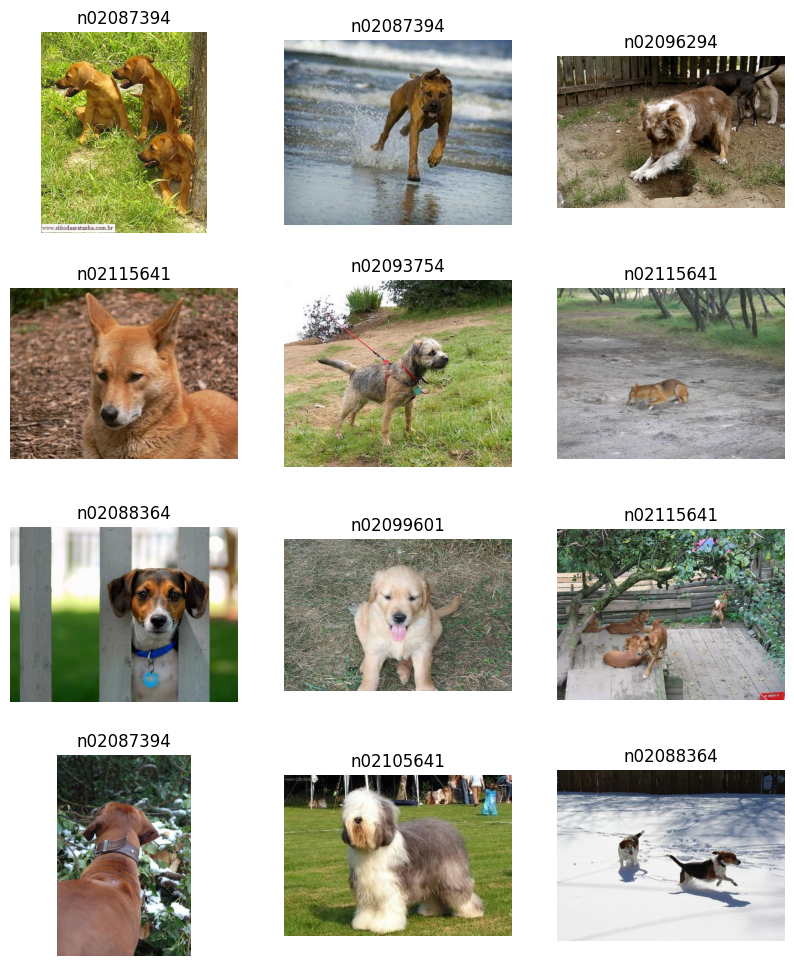

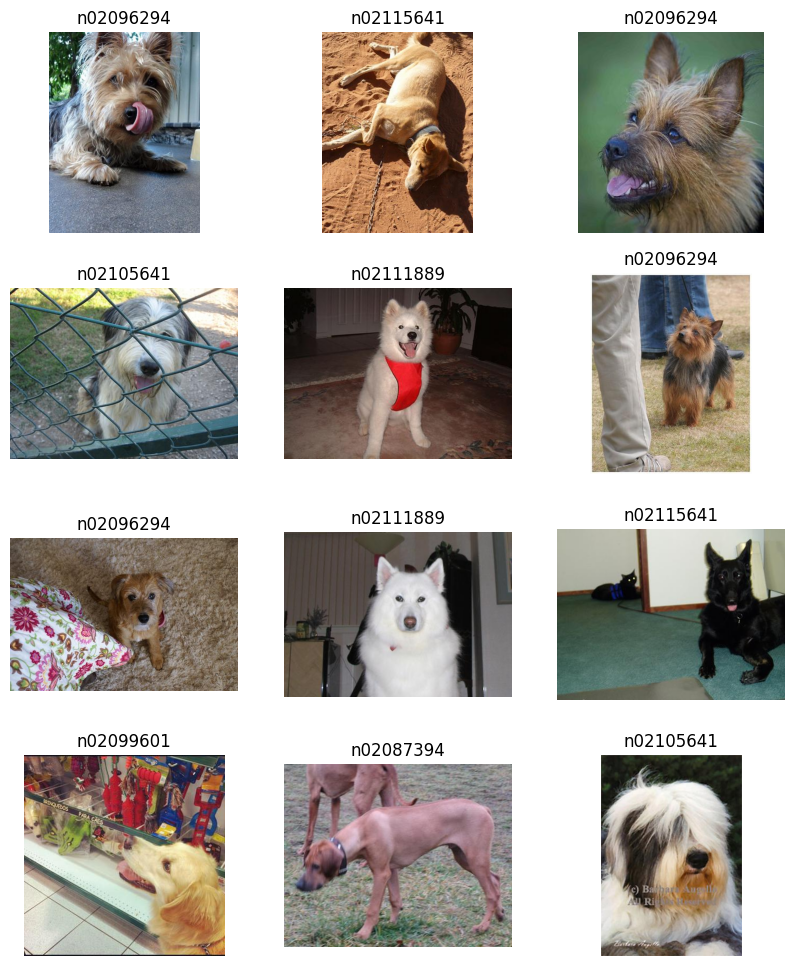

In [8]:
#Visualizing the training and validation sets

fig, axis = plt.subplots(4, 3,figsize=(10, 12))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(Train_df.Train_filepath[i]))
    ax.set_title(Train_df.Train_Labels[i])
    ax.axis('off')   
plt.show()

fig, axis = plt.subplots(4, 3,figsize=(10, 12))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(Val_df.Val_filepath[i]))
    ax.set_title(Val_df.Val_Labels[i])
    ax.axis('off')   
plt.show()

In [9]:
labels = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 
          'n02099601', 'n02105641', 'n02111889', 'n02115641']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Now we can easily fetch our train and validation sets.
train = get_data('/home/cqdx/Clinton/image_data/Data/train')
val = get_data('/home/cqdx/Clinton/image_data/Data/val')

print('Number of training files:', len(train))
print('Number of validation files:', len(val))

Number of training files: 12454
Number of validation files: 500


# Applying Data Augmentation to images

In [10]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = to_categorical(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = to_categorical(y_val)



#Applying Data Augmentation to images
datagen = ImageDataGenerator(
        featurewise_center=False,  # we will set input mean to 0 over the dataset
        samplewise_center=False,  # we will also set each sample mean to 0
        featurewise_std_normalization=False,  # we will divide the inputs by std of the dataset
        samplewise_std_normalization=False,  # we will also divide each input by its std
        zca_whitening=False,  # we will appy apply ZCA whitening
        rotation_range = 30,  # we will randomly rotate images in the range (degrees, between 0 to 180)
        zoom_range = 0.2, # we will randomly zoom the image 
        width_shift_range=0.1,  # we will randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # we will equally randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # we will randomly flip images
        vertical_flip=False)  # we will randomly flip images


datagen.fit(x_train)




# Transfer learning using Pre-trained ResNet 50 model 

We will make use of ResNet50 deep learning model as the pre-trained model for feature extraction for Transfer Learning.To achieve this, we will remove the last FC layers of the pre-trained ResNet50 model and replace them with our own FC layers. In addition, the weights of ResNet50 is normally used as feature extractor. Again, the Weights of the pre-trained model can also be frozen and are not updated during the training process.

# Build a Pre-trained ResNet 50 Model

In [20]:
#Image dimension
IMAGE_SIZE = 256

# Defining the Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)(inputs)
base_model.trainable = False
outputs1 = GlobalMaxPooling2D()(base_model)
dropout1 = Dropout(0.1)(outputs1)
dense_1 = Dense(512, activation='relu')(dropout1)
dropout2 = Dropout(0.1)(dense_1)
batch_Norm = BatchNormalization()(dropout2)
outputs2 = Dense(10, activation='softmax')(batch_Norm)

model = Model(inputs, outputs2)


model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048

# Plot the evaluation metrics for all the epochs 

In [12]:
# Plot the evaluation metrics for all the epochs 
def plot_histories(histories):
    
    # Input: histories obtained from training using fit_generator
    plt.style.use('classic')
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "20"
    for h, history in enumerate(histories):
        keys = history.history.keys()
        fig, axs = plt.subplots(1, len(keys)//2, figsize = (20, 6))
        fig.suptitle('Training Results' , fontsize=30)

        for k, key in enumerate(list(keys)[:len(keys)//2]):
            training = history.history[key]
            validation = history.history['val_' + key]

            epoch_count = range(1, len(training) + 1)

            axs[k].plot(epoch_count, training, 'r--', linewidth=3)
            axs[k].plot(epoch_count, validation, 'b-', linewidth=3)
            axs[k].grid('on')
            axs[k].legend(['Training ' + key, 'Validation ' + key], loc='best')
           
    
    with open(str(h+1) + '_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
        
    
# Confusion matrix  

def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    sns.set(font_scale=1.5)
    
    labelss = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7", "Class8", "Class9", "Class10"]
    
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(confusionMatx, cmap='coolwarm', square=False, annot = True, linewidth = 0.5, fmt = ".2f", xticklabels=labelss, yticklabels=labelss)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(precision, cmap='coolwarm', square=False, annot = True, linewidth = 0.5, fmt = ".2f", xticklabels=labelss, yticklabels=labelss)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()

    print("-"*125)
    
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(recall, cmap='coolwarm', square=False, annot = True, linewidth = 0.5, fmt = ".2f", xticklabels=labelss, yticklabels=labelss)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()
    

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports(y_pred, y_test):
    classification = classification_report(y_test, y_pred)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    print('Classification:', classification)
    print('Confusion', confusion)
    print('OA = :', np.array(oa))
    print('AA = :', np.array(aa))
    print('Kappa = :', np.array(kappa))
    print('Each Accuracy', np.array(list(each_acc)) * 100)
    return classification, confusion, np.array([oa, aa, kappa] + list(each_acc)) * 100


# Compile Model

In [14]:
lr = 1e-4       # Learning rate
batch_size = 32 # Batch size
epoch = 20     # Epoch

filename='/home/cqdx/Clinton/image_data/Data/logs.csv'
history_logger = tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

# Define optimization and train method
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=5, 
                              min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath="/home/cqdx/Clinton/image_data/Data/checkpoint.hdf5", verbose=1, 
                              save_best_only=False)

# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adms = Adam(lr=0.0001, decay=0.00001)

# Compiling the model
model.compile(optimizer=adms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Trained model path
checkpoint_path = '/home/cqdx/Clinton/image_data/Data/checkpoint.hdf5'

#Reacord Time
start = time.time()

# Training the model
history = model.fit(x=x_train, y=y_train, batch_size=batch_size,
                        epochs=epoch, validation_data=(x_val, y_val), verbose=1, 
                        callbacks=[reduce_lr, checkpointer, history_logger], shuffle=True)

stop = time.time()
print(f"Training time: {stop - start}s")



Train on 12454 samples, validate on 500 samples
Epoch 1/20
12448/12454 [============================>.] - ETA: 0s - loss: 0.2531 - accuracy: 0.9189
Epoch 00001: saving model to /home/cqdx/Clinton/image_data/Data/checkpoint.hdf5
12454/12454 [==============================] - 75s 6ms/sample - loss: 0.2533 - accuracy: 0.9188 - val_loss: 1.2558 - val_accuracy: 0.6600
Epoch 2/20
12448/12454 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9579
Epoch 00002: saving model to /home/cqdx/Clinton/image_data/Data/checkpoint.hdf5
12454/12454 [==============================] - 69s 6ms/sample - loss: 0.1265 - accuracy: 0.9579 - val_loss: 0.4956 - val_accuracy: 0.8760
Epoch 3/20
12448/12454 [============================>.] - ETA: 0s - loss: 0.0783 - accuracy: 0.9758
Epoch 00003: saving model to /home/cqdx/Clinton/image_data/Data/checkpoint.hdf5
12454/12454 [==============================] - 69s 6ms/sample - loss: 0.0783 - accuracy: 0.9758 - val_loss: 0.6354 - val_accuracy: 0.836

# Feature Plots

Evaluation scores from pretrained model:
Accuracy:  [0.872]
Loss:  [0.6513364052814431]
Training time: 1392.5573768615723s


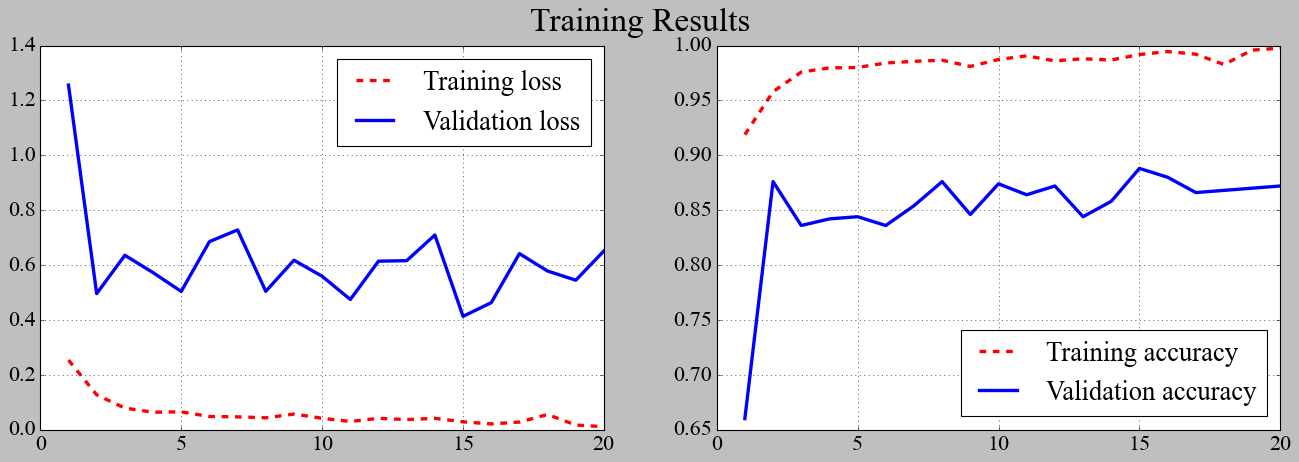

In [15]:
histories = []
losses = []
accuracies = []

from tensorflow.keras.models import load_model
TL_model = load_model(checkpoint_path)

TL_model.compile(optimizer=adms, loss='categorical_crossentropy', metrics=['accuracy'])

results = TL_model.evaluate(x_val, y_val, verbose=False)
results = dict(zip(TL_model.metrics_names,results))

histories.append(history)
accuracies.append(results['accuracy'])
losses.append(results['loss'])


print('Evaluation scores from pretrained model:')
print('Accuracy: ', accuracies)
print('Loss: ', losses)
print(f"Training time: {stop - start}s")

plot_histories(histories)

# Confusion Matrix

Accuracy on Image Test Data = 87.2%


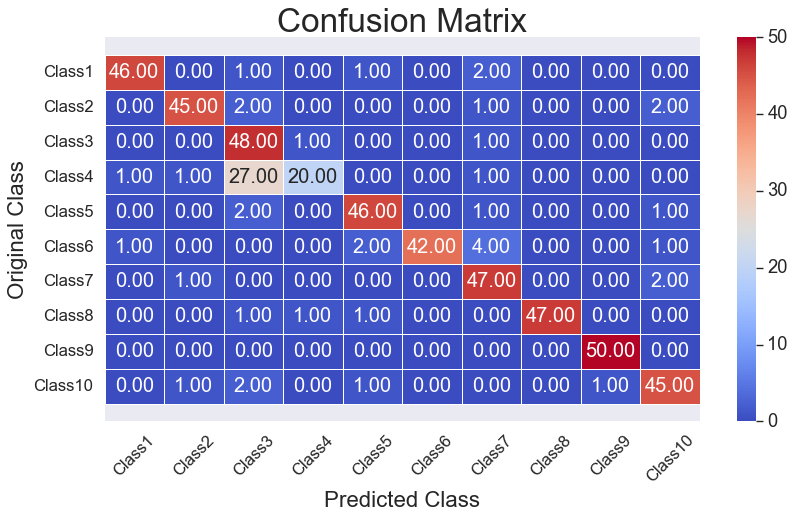

-----------------------------------------------------------------------------------------------------------------------------


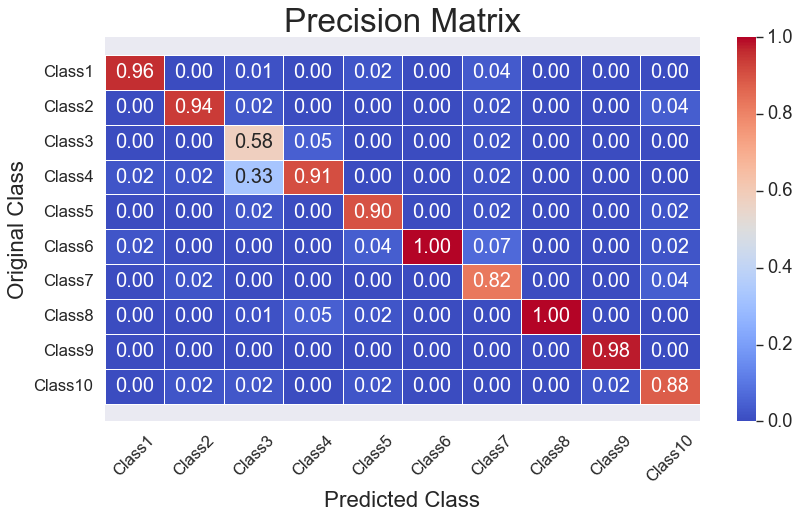

-----------------------------------------------------------------------------------------------------------------------------


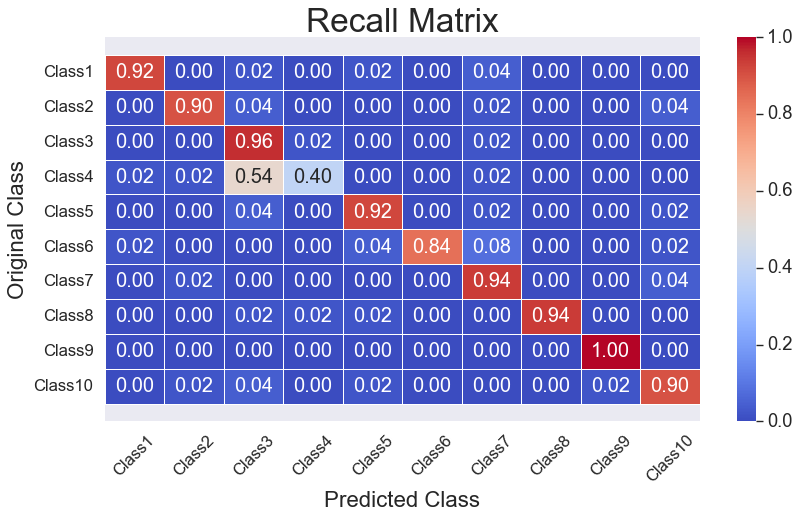

In [18]:
X_test = x_val.astype('float')
X_test = X_test.reshape(-1, 256, 256, 3)
pred = np.argmax(model.predict(X_test), axis=1)
y_test_pred = np.argmax(y_val, 1)

acc = accuracy_score(y_test_pred, pred)
print("Accuracy on Image Test Data = {}%".format(np.round(float(acc*100), 2)))
print_confusionMatrix(y_test_pred, pred)



In [19]:
Report = reports(pred, y_test_pred)

Classification:               precision    recall  f1-score   support

           0       0.96      0.92      0.94        50
           1       0.94      0.90      0.92        50
           2       0.58      0.96      0.72        50
           3       0.91      0.40      0.56        50
           4       0.90      0.92      0.91        50
           5       1.00      0.84      0.91        50
           6       0.82      0.94      0.88        50
           7       1.00      0.94      0.97        50
           8       0.98      1.00      0.99        50
           9       0.88      0.90      0.89        50

    accuracy                           0.87       500
   macro avg       0.90      0.87      0.87       500
weighted avg       0.90      0.87      0.87       500

Confusion [[46  0  1  0  1  0  2  0  0  0]
 [ 0 45  2  0  0  0  1  0  0  2]
 [ 0  0 48  1  0  0  1  0  0  0]
 [ 1  1 27 20  0  0  1  0  0  0]
 [ 0  0  2  0 46  0  1  0  0  1]
 [ 1  0  0  0  2 42  4  0  0  1]
 [ 0  1  0  0  0 